In [ ]:
import pandas as pd
import os
from tqdm import tqdm 
tqdm.pandas()

In [ ]:
from datetime import datetime

base_path = "./Data"

output_path = os.path.join(base_path,"combined_tweets.csv")
chunks = []


# Iterating through all *.csv.gz
all_files = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".csv.gz"):
            print(f'Reading {file}')
            df = pd.read_csv(os.path.join(base_path,file), compression="gzip", low_memory=False)
            df = df[(pd.to_datetime(df['date'])>=datetime(2024,11,3)) & (pd.to_datetime(df['date'])<=datetime(2024,11,7))]
            chunks.append(df)

# Cincating
combined_df = pd.concat(chunks, ignore_index=True)

# Saving to combined df
combined_df.to_csv(output_path, index=False)
print(f"Готово! Сохранено в: {output_path}")


Reading november_chunk_1.csv.gz
Reading november_chunk_10.csv.gz
Reading november_chunk_100.csv.gz
Reading november_chunk_101.csv.gz
Reading november_chunk_102.csv.gz
Reading november_chunk_103.csv.gz
Reading november_chunk_104.csv.gz
Reading november_chunk_105.csv.gz
Reading november_chunk_106.csv.gz
Reading november_chunk_107.csv.gz
Reading november_chunk_108.csv.gz
Reading november_chunk_109.csv.gz
Reading november_chunk_11.csv.gz
Reading november_chunk_110.csv.gz
Reading november_chunk_111.csv.gz
Reading november_chunk_112.csv.gz
Reading november_chunk_113.csv.gz
Reading november_chunk_12.csv.gz
Reading november_chunk_13.csv.gz
Reading november_chunk_14.csv.gz
Reading november_chunk_15.csv.gz
Reading november_chunk_16.csv.gz
Reading november_chunk_17.csv.gz
Reading november_chunk_18.csv.gz
Reading november_chunk_19.csv.gz
Reading november_chunk_2.csv.gz
Reading november_chunk_20.csv.gz
Reading november_chunk_21.csv.gz
Reading november_chunk_22.csv.gz
Reading november_chunk_23.csv.g

C:\Users\kpale\AppData\Local\Temp\ipykernel_58212\3966090209.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(chunks, ignore_index=True)


Готово! Сохранено в: ./Data\combined_tweets.csv


In [7]:
combined_df.iloc[0].user

NameError: name 'combined_df' is not defined

In [3]:
tweets = pd.read_csv(r'./Data/combined_tweets_lemmatized_with_lang_and_sentiment.csv')#combined_df#pd.read_csv(r'./Data/part_39/tweets_lemmatized.csv')#pd.concat([df1,df2], ignore_index=True)
len(tweets)

268121

In [9]:
tweets['date'].value_counts()

date
2024-11-07    263792
2024-11-06     70440
2024-11-05      2461
2024-11-03      1897
2024-11-04      1520
Name: count, dtype: int64

In [4]:
tweets['datetime'] = pd.to_datetime(tweets['epoch'], unit='s')
tweets['tweet_hour'] = tweets['datetime'].dt.floor('h')

In [3]:
tweets['tweet_hour']

0         2024-11-07 05:00:00
1         2024-11-07 05:00:00
2         2024-11-07 05:00:00
3         2024-11-07 05:00:00
4         2024-11-07 05:00:00
                 ...         
340105    2024-11-07 05:00:00
340106    2024-11-07 05:00:00
340107    2024-11-07 05:00:00
340108    2024-11-07 05:00:00
340109    2024-11-07 05:00:00
Name: tweet_hour, Length: 340110, dtype: object

In [ ]:
import re
from datetime import datetime
import ast

#Replace datetime(...) with ISO-string ---
def replace_datetime(match):
    dt_args = match.group(1)
    try:
        #Removing named args (i.e., tzinfo=...)
        args = [arg.strip() for arg in dt_args.split(',') if '=' not in arg]
        dt = datetime(*map(int, args[:6]))  # Only 6 first positional args
        return f'"{dt.isoformat()}"'  # Returning as string in quotes
    except Exception as e:
        print("Error when parsing datetime:", dt_args, e)
        return '"1970-01-01T00:00:00"'

#Safe parsing for the dirty json-string
def parse_dirty_json(s):
    try:
        #Replacing datetime(...) → "2022-11-11T19:16:00"
        s_clean = re.sub(r"\w+\.datetime\((.*?)\)", replace_datetime, s)

        #Converting to python dict
        obj = ast.literal_eval(s_clean)
        # Reading as JSON
        return obj
    except Exception as e:
        print("❌ Error when processing string:", e)
        return None

In [8]:
tweets['user_clean_json'] = tweets['user'].progress_apply(parse_dirty_json)

100%|██████████| 340110/340110 [02:29<00:00, 2282.36it/s]


In [9]:
tweets['hashtags_clean'] = tweets.hashtags.progress_apply(lambda x: [y['text'] for y in parse_dirty_json(x)])

100%|██████████| 340110/340110 [00:11<00:00, 28565.55it/s]


In [10]:
tweets['user_id'] = tweets['user_clean_json'].apply(lambda x: x['id'])

In [10]:
tweets.columns

Index(['id', 'username', 'text', 'url', 'epoch', 'retweetedTweet',
       'retweetedTweetID', 'retweetedUserID', 'rawContent', 'replyCount',
       'retweetCount', 'likeCount', 'quoteCount', 'mentionedUsers', 'links',
       'viewCount', 'quotedTweet', 'in_reply_to_screen_name',
       'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 'location',
       'cash_app_handle', 'user', 'date', 'datetime', 'tweet_hour', 'hashtags',
       'user_id', 'clean_text', 'lemmatized'],
      dtype='object')

In [11]:
tweets = tweets.drop(columns=['0','type',"media", "id_str", "lang", "conversationId", "conversationIdStr", "hashtags", "user_clean_json"])

In [12]:
tweets.rename(columns={'hashtags_clean': 'hashtags'}, inplace=True)

In [ ]:
import re
def clean_text(text):
    text = re.sub(r"http\S+", "", text)        # removing links
    text = re.sub(r"@\w+", "", text)           # removing tags
    text = re.sub(r"#\w+", "", text)           # removing hashtags
    text = re.sub(r"[^\w\s]", "", text)        # removing punctuation
    text = re.sub(r"\d+", "", text)            # removing numbers
    text = text.lower().strip()                # lowercase and removing spaces
    return text

In [14]:
tweets["clean_text"] = tweets["text"].astype(str).apply(clean_text)

In [16]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [17]:
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

In [ ]:
lemmatized_texts = []
for doc in tqdm(nlp.pipe(tweets["clean_text"], batch_size=1000, n_process=1), total=len(tweets)):
    lemmatized_texts.append(" ".join([token.lemma_ for token in doc if not token.is_stop]))

tweets["lemmatized"] = lemmatized_texts


  0%|          | 0/340110 [00:00<?, ?it/s]

100%|██████████| 340110/340110 [26:44<00:00, 211.93it/s] 


In [ ]:
tweets = tweets.dropna(subset=["lemmatized"])  # removing rows with no text

In [20]:
len(tweets)
tweets.to_csv(r'./Data/combined_tweets_lemmatized.csv',index=False)

In [11]:
import langid
from tqdm import tqdm
tqdm.pandas()

tweets["lang"] = tweets["text"].progress_apply(lambda x: langid.classify(x)[0] if isinstance(x, str) else None)

  0%|          | 0/340110 [00:00<?, ?it/s]

100%|██████████| 340110/340110 [07:08<00:00, 794.14it/s]


In [12]:
tweets['lang'].value_counts()

lang
en    268121
es     22008
fr     10214
pt      5357
de      3389
       ...  
mn         3
as         2
kk         1
be         1
mk         1
Name: count, Length: 97, dtype: int64

In [13]:
# Фильтруем только английские
tweets = tweets[tweets["lang"] == "en"]

In [14]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kpale\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = sid.polarity_scores(text)["compound"]
    if score > 0.1:
        return "positive"
    elif score < -0.1:
        return "negative"
    else:
        return "neutral"

tweets["sentiment"] = tqdm(tweets["lemmatized"].astype(str).apply(get_sentiment), total = len(tweets))

100%|██████████| 268121/268121 [00:00<00:00, 2475660.11it/s]


In [16]:
tweets.to_csv(r'./Data/combined_tweets_lemmatized_with_lang_and_sentiment.csv',index=False)

In [4]:
import pandas as pd
tweets = pd.read_csv(r'./Data/combined_tweets_lemmatized_with_lang_and_sentiment.csv')

In [5]:
tweets

,id,username,text,url,epoch,retweetedTweet,retweetedTweetID,retweetedUserID,rawContent,replyCount,...,user,date,datetime,tweet_hour,hashtags,user_id,clean_text,lemmatized,lang,sentiment
0,1.854393e+18,shehuabraham2,@ivankatrumpo Yes\nIn far does that try to kil...,https://twitter.com/shehuabraham2/status/18543...,1.730957e+09,False,NaN,NaN,@ivankatrumpo Yes\nIn far does that try to kil...,0.0,...,"{'id': 1591147489763131392, 'id_str': '1591147...",2024-11-07,2024-11-07 05:18:00,2024-11-07 05:00:00,[],1591147489763131392,yes\nin far does that try to killed daddy dona...,yes \n far try kill daddy donald trump arrest ...,en,negative
1,1.854393e+18,RPollam900,"Over time, Southern whites increasingly shifte...",https://twitter.com/RPollam900/status/18543928...,1.730957e+09,False,NaN,NaN,"Over time, Southern whites increasingly shifte...",1.0,...,"{'id': 1507777504370593795, 'id_str': '1507777...",2024-11-07,2024-11-07 05:18:00,2024-11-07 05:00:00,[],1507777504370593795,over time southern whites increasingly shifted...,time southern white increasingly shift republi...,en,positive
2,1.854393e+18,RPollam900,"This led to a ""Southern Strategy,"" where the R...",https://twitter.com/RPollam900/status/18543928...,1.730957e+09,False,NaN,NaN,"This led to a ""Southern Strategy,"" where the R...",1.0,...,"{'id': 1507777504370593795, 'id_str': '1507777...",2024-11-07,2024-11-07 05:18:00,2024-11-07 05:00:00,[],1507777504370593795,this led to a southern strategy where the repu...,lead southern strategy republican party start ...,en,positive
3,1.854393e+18,aalianadim,"@MarioNawfal A new coalition, a new Republican...",https://twitter.com/aalianadim/status/18543928...,1.730957e+09,False,NaN,NaN,"@MarioNawfal A new coalition, a new Republican...",0.0,...,"{'id': 1831664841976688640, 'id_str': '1831664...",2024-11-07,2024-11-07 05:18:00,2024-11-07 05:00:00,[],1831664841976688640,a new coalition a new republican party and ame...,new coalition new republican party america,en,positive
4,1.854393e+18,Gracefulglimmer,This was a blessing in disguise 😂😂\n\nTrump Ka...,https://twitter.com/Gracefulglimmer/status/185...,1.730957e+09,False,NaN,NaN,This was a blessing in disguise 😂😂\n\nTrump Ka...,25.0,...,"{'id': 1727031484517597184, 'id_str': '1727031...",2024-11-07,2024-11-07 05:17:59,2024-11-07 05:00:00,[],1727031484517597184,this was a blessing in disguise \n\ntrump kama...,blessing disguise \n\n trump kamala harris car...,en,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268116,1.854393e+18,RPollam900,...while the Democratic Party has largely beco...,https://twitter.com/RPollam900/status/18543928...,1.730957e+09,False,NaN,NaN,...while the Democratic Party has largely beco...,0.0,...,"{'id': 1507777504370593795, 'id_str': '1507777...",2024-11-07,2024-11-07 05:18:02,2024-11-07 05:00:00,[],1507777504370593795,while the democratic party has largely become ...,democratic party largely advocate civil right ...,en,positive
268117,1.854393e+18,KaaShu99,@notyour_kainat3 Cangulation Donald trump',https://twitter.com/KaaShu99/status/1854392847...,1.730957e+09,False,NaN,NaN,@notyour_kainat3 Cangulation Donald trump',0.0,...,"{'id': 1554726121068961793, 'id_str': '1554726...",2024-11-07,2024-11-07 05:18:02,2024-11-07 05:00:00,[],1554726121068961793,cangulation donald trump,cangulation donald trump,en,neutral
268118,1.854393e+18,RPollam900,This complex shift of values over time led to ...,https://twitter.com/RPollam900/status/18543928...,1.730957e+09,False,NaN,NaN,This complex shift of values over time led to ...,1.0,...,"{'id': 1507777504370593795, 'id_str': '1507777...",2024-11-07,2024-11-07 05:18:02,2024-11-07 05:00:00,[],1507777504370593795,this complex shift of values over time led to ...,complex shift value time lead current politica...,en,positive
268119,1.854393e+18,PriyankaLahiri_,The biggest like people are telling themselves...,https://twitter.com/PriyankaLahiri_/status/185...,1.730957e+09,False,NaN,NaN,The b

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm
import numpy as np

tweets["lemmatized"] = tweets["lemmatized"].fillna("").astype(str)


custom_stopwords = [
    "people", "thing", "know", "want", "think", "say", "said",
    "election", "vote", "voting", "joe", "biden", "donald", "trump", "campaign",
    "harris", "kamala", "election", "win", "vance"
]

max_features = 10000
topic_range = range(2, 10)


lda_models = []
vectorizers = []
X_matrices = []
filtered_words_list = []
log_likelihoods = []
perplexities = []

tqdm.write("🚀 Starting LDA topic modeling...\n")

for n_topics in tqdm(topic_range, desc="Training models", unit="model"):
    tqdm.write(f"\n🔹 [{n_topics} topics] Initializing CountVectorizer...")

    vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
    X = vectorizer.fit_transform(tweets['lemmatized'])
    words = vectorizer.get_feature_names_out()

    tqdm.write(f"   📐 Shape of X: {X.shape[0]} docs × {X.shape[1]} features")

    word_mask = [w not in custom_stopwords for w in words]
    X_filtered = X[:, word_mask]
    words_filtered = words[word_mask]

    tqdm.write(f"   🚫 Custom stopwords removed: {np.sum(np.logical_not(word_mask))}")
    tqdm.write(f"   ✅ Remaining vocab: {X_filtered.shape[1]}")

    lda = LatentDirichletAllocation(n_components=n_topics,
        max_iter=10,
        random_state=42,
        verbose=1,
        learning_method='batch')
    tqdm.write("   🔄 Fitting LDA model...")
    lda.fit(X_filtered)

    tqdm.write(f"   🧠 Model trained with {n_topics} topics")

    # 📊 Saving metrics
    ll = lda.score(X_filtered)
    perp = lda.perplexity(X_filtered)
    log_likelihoods.append(ll)
    perplexities.append(perp)
    tqdm.write(f"   📈 Log-likelihood: {ll:.2f} | Perplexity: {perp:.2f}")

    # 💾 Saving other data
    lda_models.append(lda)
    vectorizers.append(vectorizer)
    X_matrices.append(X_filtered)
    filtered_words_list.append(words_filtered)
    tqdm.write(f"   💾 Saved at index {n_topics - topic_range.start}")



🚀 Starting LDA topic modeling...



Training models:   0%|          | 0/8 [00:00<?, ?model/s]


🔹 [2 topics] Initializing CountVectorizer...


Training models:   0%|          | 0/8 [00:03<?, ?model/s]

   📐 Shape of X: 268121 docs × 10000 features
   🚫 Custom stopwords removed: 18
   ✅ Remaining vocab: 9982
   🔄 Fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Training models:   0%|          | 0/8 [20:04<?, ?model/s]

   🧠 Model trained with 2 topics


Training models:  12%|█▎        | 1/8 [24:12<2:49:27, 1452.54s/model]

   📈 Log-likelihood: -19066409.10 | Perplexity: 1982.95
   💾 Saved at index 0

🔹 [3 topics] Initializing CountVectorizer...


Training models:  12%|█▎        | 1/8 [24:24<2:49:27, 1452.54s/model]

   📐 Shape of X: 268121 docs × 10000 features
   🚫 Custom stopwords removed: 18
   ✅ Remaining vocab: 9982
   🔄 Fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Training models:  12%|█▎        | 1/8 [49:45<2:49:27, 1452.54s/model]

   🧠 Model trained with 3 topics


Training models:  25%|██▌       | 2/8 [53:46<2:44:11, 1641.89s/model]

   📈 Log-likelihood: -19023662.62 | Perplexity: 1949.48
   💾 Saved at index 1

🔹 [4 topics] Initializing CountVectorizer...


Training models:  25%|██▌       | 2/8 [53:54<2:44:11, 1641.89s/model]

   📐 Shape of X: 268121 docs × 10000 features
   🚫 Custom stopwords removed: 18
   ✅ Remaining vocab: 9982
   🔄 Fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Training models:  25%|██▌       | 2/8 [1:04:29<2:44:11, 1641.89s/model]

   🧠 Model trained with 4 topics


Training models:  38%|███▊      | 3/8 [1:06:22<1:43:06, 1237.33s/model]

   📈 Log-likelihood: -19009925.83 | Perplexity: 1938.85
   💾 Saved at index 2

🔹 [5 topics] Initializing CountVectorizer...


Training models:  38%|███▊      | 3/8 [1:06:29<1:43:06, 1237.33s/model]

   📐 Shape of X: 268121 docs × 10000 features
   🚫 Custom stopwords removed: 18
   ✅ Remaining vocab: 9982
   🔄 Fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Training models:  38%|███▊      | 3/8 [1:15:47<1:43:06, 1237.33s/model]

   🧠 Model trained with 5 topics


Training models:  50%|█████     | 4/8 [1:17:00<1:06:42, 1000.52s/model]

   📈 Log-likelihood: -19010252.49 | Perplexity: 1939.10
   💾 Saved at index 3

🔹 [6 topics] Initializing CountVectorizer...


Training models:  50%|█████     | 4/8 [1:17:04<1:06:42, 1000.52s/model]

   📐 Shape of X: 268121 docs × 10000 features
   🚫 Custom stopwords removed: 18
   ✅ Remaining vocab: 9982
   🔄 Fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Training models:  50%|█████     | 4/8 [1:26:22<1:06:42, 1000.52s/model]

   🧠 Model trained with 6 topics


Training models:  62%|██████▎   | 5/8 [1:28:47<44:43, 894.61s/model]   

   📈 Log-likelihood: -19031078.74 | Perplexity: 1955.25
   💾 Saved at index 4

🔹 [7 topics] Initializing CountVectorizer...


Training models:  62%|██████▎   | 5/8 [1:28:54<44:43, 894.61s/model]

   📐 Shape of X: 268121 docs × 10000 features
   🚫 Custom stopwords removed: 18
   ✅ Remaining vocab: 9982
   🔄 Fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Training models:  62%|██████▎   | 5/8 [1:38:38<44:43, 894.61s/model]

   🧠 Model trained with 7 topics


Training models:  75%|███████▌  | 6/8 [1:40:07<27:23, 821.87s/model]

   📈 Log-likelihood: -19040505.52 | Perplexity: 1962.60
   💾 Saved at index 5

🔹 [8 topics] Initializing CountVectorizer...


Training models:  75%|███████▌  | 6/8 [1:40:12<27:23, 821.87s/model]

   📐 Shape of X: 268121 docs × 10000 features
   🚫 Custom stopwords removed: 18
   ✅ Remaining vocab: 9982
   🔄 Fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Training models:  75%|███████▌  | 6/8 [8:58:21<27:23, 821.87s/model]

   🧠 Model trained with 8 topics


Training models:  88%|████████▊ | 7/8 [9:00:11<2:33:05, 9185.25s/model]

   📈 Log-likelihood: -19079077.63 | Perplexity: 1992.98
   💾 Saved at index 6

🔹 [9 topics] Initializing CountVectorizer...


Training models:  88%|████████▊ | 7/8 [9:00:18<2:33:05, 9185.25s/model]

   📐 Shape of X: 268121 docs × 10000 features
   🚫 Custom stopwords removed: 18
   ✅ Remaining vocab: 9982
   🔄 Fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Training models:  88%|████████▊ | 7/8 [9:15:19<2:33:05, 9185.25s/model]

   🧠 Model trained with 9 topics


Training models: 100%|██████████| 8/8 [9:18:52<00:00, 4191.51s/model]  

   📈 Log-likelihood: -19081590.79 | Perplexity: 1994.97
   💾 Saved at index 7


C:\Users\kpale\AppData\Local\Temp\ipykernel_15488\239054262.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kpale\AppData\Local\Temp\ipykernel_15488\239054262.py:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Code\US Election sentiment\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Code\US Election sentiment\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


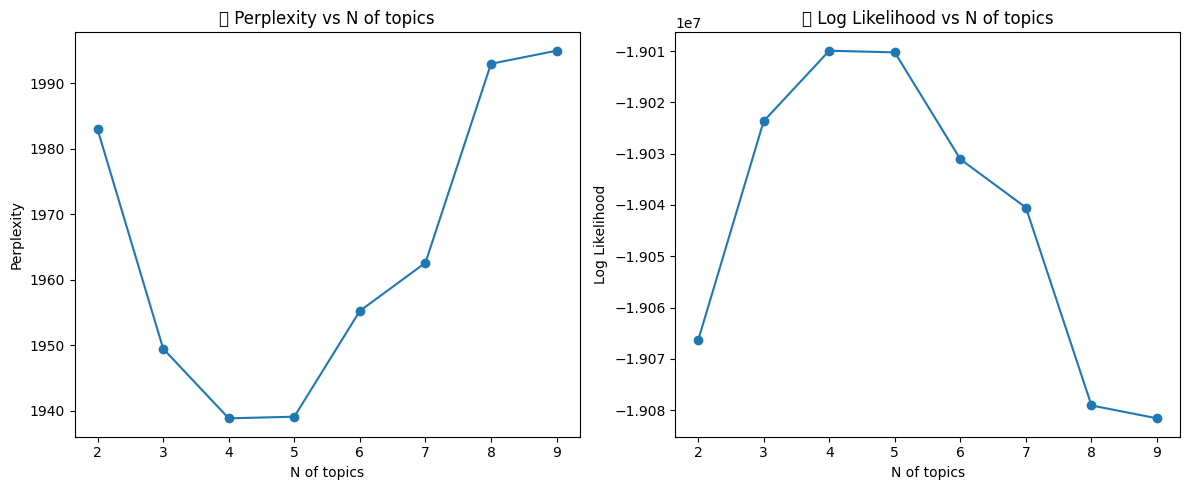

In [ ]:
# Results visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(topic_range, perplexities, marker='o')
plt.title("📉 Perplexity vs N of topics")
plt.xlabel("N of topics")
plt.ylabel("Perplexity")

plt.subplot(1, 2, 2)
plt.plot(topic_range, log_likelihoods, marker='o')
plt.title("📈 Log Likelihood vs N of topics")
plt.xlabel("N of topics")
plt.ylabel("Log Likelihood")

plt.tight_layout()
plt.show()

In [ ]:
from gensim import corpora
from gensim.models import CoherenceModel

tokenized_texts = [text.split() for text in tweets.lemmatized]

dictionary = corpora.Dictionary(tokenized_texts)

corpus = [dictionary.doc2bow(text) for text in tokenized_texts]


In [ ]:
coherence_scores = []

for i, lda_model in enumerate(lda_models):
    words_filtered = filtered_words_list[i]

    # Getting topics as a list of lists of words
    topics = []
    for topic in lda_model.components_:
        top_indices = topic.argsort()[-10:][::-1]
        topic_words = [words_filtered[i] for i in top_indices]
        topics.append(topic_words)

    # Building coherence model
    cm = CoherenceModel(
        topics=topics,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v' 
    )
    coherence = cm.get_coherence()
    coherence_scores.append(coherence)

    print(f"✅ Coherence @ {topic_range[i]} topics: {coherence:.4f}")


✅ Coherence @ 2 topics: 0.4048
✅ Coherence @ 3 topics: 0.4861
✅ Coherence @ 4 topics: 0.4848
✅ Coherence @ 5 topics: 0.5264
✅ Coherence @ 6 topics: 0.5196
✅ Coherence @ 7 topics: 0.5094
✅ Coherence @ 8 topics: 0.4783
✅ Coherence @ 9 topics: 0.5028


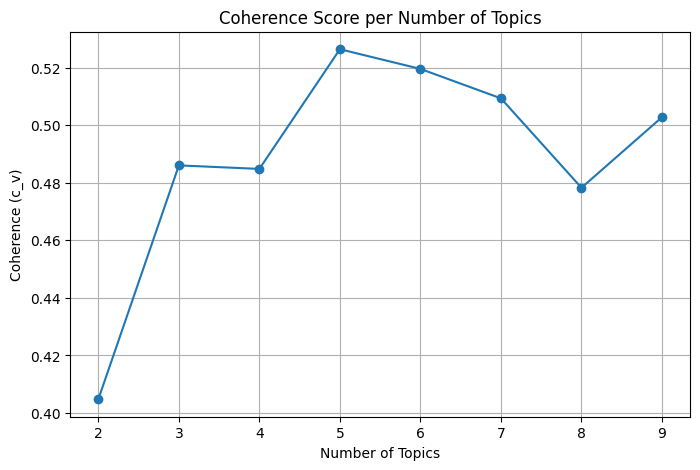

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(list(topic_range), coherence_scores, marker='o')
plt.title("Coherence Score per Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence (c_v)")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

custom_stopwords = [
    "people", "thing", "know", "want", "think", "say", "said",
    "election", "vote", "voting", "joe", "biden", "donald", "trump", "campaign",
    "harris", "kamala", "election", "win", "vance"
]
print("🔠 Vectorization...")
vectorizer = CountVectorizer(
    max_df=0.85,
    min_df=10,
    max_features=5000,
    stop_words="english"
)
vectorizer.stop_words_ = vectorizer.get_stop_words().union(custom_stopwords)
dtm = vectorizer.fit_transform(tqdm(tweets["lemmatized"], desc="Texts"))

🔠 Vectorization...


Texts:   0%|          | 0/268121 [00:00<?, ?it/s]

In [13]:
best_index = coherence_scores.index(max(coherence_scores))

In [22]:
best_model = lda_models[best_index]
best_words = filtered_words_list[best_index]

def print_top_words(model, words, n=15):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n:][::-1]
        top_words = [words[i] for i in top_indices]
        print(f"🧠 Topic {topic_idx + 1}: {', '.join(top_words)}")

print_top_words(best_model, best_words, 15)

🧠 Topic 1: like, right, president, need, good, fuck, come, feel, fight, time, tell, look, year, country, let
🧠 Topic 2: america, speech, god, president, thank, great, world, elon, amp, love, musk, work, country, good, concession
🧠 Topic 3: victory, president, million, new, presidential, presidentelect, term, congratulation, return, united, second, political, billion, states, american
🧠 Topic 4: president, woman, white, man, black, lose, house, presidential, vice, th, race, united, concede, states, elect
🧠 Topic 5: party, democratic, republican, need, like, work, right, democrat, green, class, year, democrats, leave, lose, voter
🧠 Topic 6: dnc, candidate, lose, run, time, voter, like, medium, lie, state, year, amp, million, bad, primary


In [26]:
best_index

4

In [ ]:
lda_model = best_model

# Tweets vectorization
X = X_matrices[best_index]

# Topics distribution
topic_probs = lda_model.transform(X)  # shape: (n_docs, n_topics)

# Detection of the most competable topic per tweet
tweets['dominant_topic'] = topic_probs.argmax(axis=1)

# Probability of belonging to the topic per tweet
tweets['topic_prob'] = topic_probs.max(axis=1)

# Examples
print(tweets[['lemmatized', 'dominant_topic', 'topic_prob']].sample(10))


                                               lemmatized  dominant_topic  \
65872   protect filibuster important vast majority tru...               4   
102152  poll say   people certain battleground state v...               5   
80207   frustrated hispaniclatino voter post rmoderate...               5   
121886  not add inability understand democratic party ...               4   
5424                                                                    0   
20446   yes person need s indictment day   new rule de...               0   
124433          tell dnc wrong choice instead snivel worm               5   
133449  donald trump blame democrats kamala harris joe...               5   
49001   not want laugh clown call kamala harris \n tha...               1   
153305  republican s news vote dnc spout dem propogand...               5   

        topic_prob  
65872     0.882102  
102152    0.923438  
80207     0.612345  
121886    0.940192  
5424      0.166667  
20446     0.524257  
12443

In [ ]:
# Fraction of positive and negative tweets per topic
polarization = tweets.groupby("dominant_topic")["sentiment"].value_counts(normalize=True).unstack().fillna(0)
polarization["polarization_score"] = (polarization["positive"] - polarization["negative"]).abs()

print(polarization[["positive", "negative", "polarization_score"]])

sentiment       positive  negative  polarization_score
dominant_topic                                        
0               0.368477  0.328431            0.040046
1               0.631859  0.189876            0.441984
2               0.509514  0.237408            0.272106
3               0.416914  0.297100            0.119815
4               0.598122  0.287292            0.310831
5               0.377768  0.415974            0.038205


In [29]:
tweets.to_csv("tweets_processed.csv", index=False)

In [30]:
polarization.to_csv("topic_polarization_scores.csv")